In [1]:
# This notebook runs from the projects root directory.
import os
PROJECT_ROOT_DIRECTORY = 'senior_project'
while os.path.basename(os.getcwd()) != PROJECT_ROOT_DIRECTORY:
    os.chdir(os.pardir)
print('Current working directory:', os.getcwd())

Current working directory: c:\Users\pavan\Desktop\senior_project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from stable_baselines3 import DQN, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from environments.discrete_env_v2 import PortfolioManagementEnv

In [5]:
train_df = pd.read_csv('data\dow_10_stationary_features_train.csv', index_col=0, parse_dates=True)
val_df = pd.read_csv('data\dow_10_stationary_features_val.csv', index_col=0, parse_dates=True)

TICKERS = ['AXP', 'AAPL', 'BA', 'GS', 'INTC', 'JNJ', 'KO', 'NKE', 'PG', 'DIS']
FEATURES = ['RETURN_12', 'RETURN_26', 'RETURN_60', 'STD_20']

RETURN_COLS = ['RISK_FREE'] + [ticker for ticker in TICKERS]
FEATURE_COLS = RETURN_COLS + [f'{ticker}_{feature}' for ticker in TICKERS for feature in FEATURES]

In [7]:
envs = DummyVecEnv([
    lambda: PortfolioManagementEnv(
        train_df, 
        RETURN_COLS, 
        FEATURE_COLS, 
        window_size=30, 
        episode_length=225, 
        allocations_in_obs=True,
    ) 
    for _ in range(8)
])

In [9]:
model = A2C(
    'MlpPolicy',
    envs,
    verbose=1,
    seed=5,
    learning_rate=0.0005,
    n_steps=5,
    gamma=0.99,
    ent_coef=0.3,
    vf_coef=0.5,
    normalize_advantage=True,
)

Using cuda device


In [10]:
model.learn(total_timesteps=500)

In [11]:
val_env = PortfolioManagementEnv(
    val_df, 
    RETURN_COLS, 
    FEATURE_COLS, 
    window_size=30,
    episode_length=-1,
    allocations_in_obs=True,
)

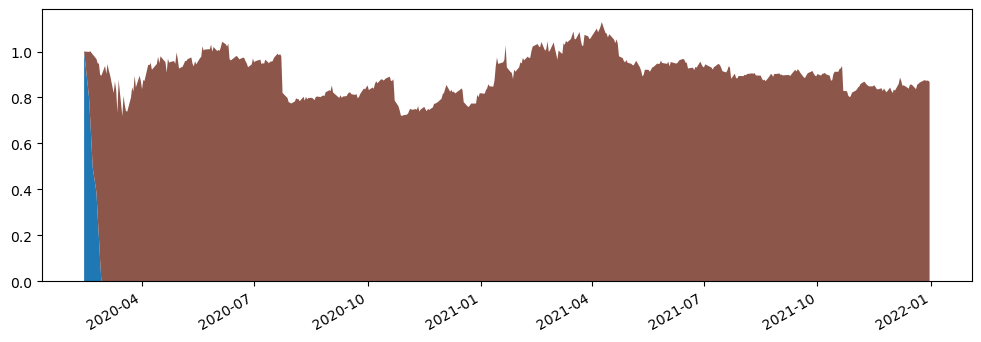

In [12]:
obs, done = val_env.reset(), False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = val_env.step(action)
val_env.render()
val_env.close()